In [1]:
grid_file = '/home/benr/src/ssm-analysis/SSM_Grid/ssm_grid.2dm'

import configparser
import re
import os

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fvcom import FvcomGrid, Transect, ControlVolume

In [2]:
data = Dataset('results/ts.nc')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(8784), node(3137), nele(4129)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 controltemp_surf(time, node), float32 controltemp_bottom(time, node), float32 controlsalinity_surf(time, node), float32 controlsalinity_bottom(time, node), float32 q1temp_surf(time, node), float32 q1temp_bottom(time, node), float32 q1salinity_surf(time, node), float32 q1salinity_bottom(time, node), float32 q3temp_surf(time, node), float32 q3temp_bottom(time, node), float32 q3salinity_surf(time, node), float32 q3salinity_bottom(time, node), float32 q5temp_surf(time, node), float32 q5temp_bottom(time, node), float32 q5salinity_surf(time, node), float32 q5salinity_bottom(time, node), float32 q7temp_surf(time, node), float32 q7temp_bottom(time, node), float32 q7salinity_su

In [3]:
def sort(vs):
    r = re.compile('q([1-9])')
    dec = []
    for v in vs:
        if v[-9:] != 'temp_surf':
            continue
        n = v[:-9] # Remove 'temp_surf'
        m = r.match(n)
        if m:
            q = m.group(1)
        elif n == 'control':
            q = '0'
        else:
                q = '0'
        dec.append((q, v))
    dec.sort()
    return [v for q, v in dec]

sort(data.variables)

['controltemp_surf',
 'q1temp_surf',
 'q3temp_surf',
 'q5temp_surf',
 'q7temp_surf',
 'q9temp_surf']

In [4]:
grid = FvcomGrid.from_mesh(grid_file)
areas = grid.tces_gdf().loc[data['node'][:]].area
areas

4478     1.290208e+06
4479     1.012244e+06
4480     1.511056e+06
4481     1.856297e+06
4482     1.190541e+06
             ...     
15989    2.452663e+05
15993    2.198963e+05
15994    1.809223e+05
16000    9.728483e+04
16003    2.510567e+05
Length: 3137, dtype: float64

In [5]:
dates = pd.Timestamp(data.model_start) + pd.to_timedelta(data['time'][:], 'D')

In [6]:
crit_depth = 20

nodes = grid.nodes_gdf()
deep_nodes = nodes.loc[np.isin(nodes.index, data['node'][:]) & (nodes['depth'] > crit_depth)]
idxs = np.searchsorted(data['node'][:], deep_nodes.index.tolist())
idxs

array([   0,    1,    2, ..., 3091, 3097, 3098])

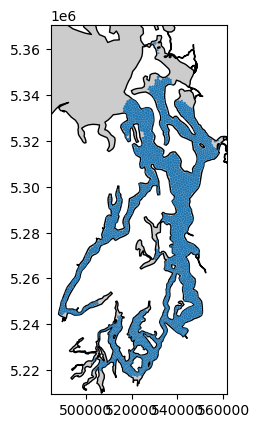

In [7]:
cv = ControlVolume(grid=grid, nodes=set(data['node'][idxs]))
cv.plot();

In [8]:
def dens(t, s):
    """Use FVCOM's DENS2 method to compute density at every cell"""
    return (((s ** 3 * 6.76786136E-6 - s ** 2 * 4.8249614E-4 + s * 8.14876577E-1 - 0.22584586) * 
       (t ** 3 * 1.667E-8 - t ** 2 * 8.164E-7 + t * 1.803E-5) +
        1 - t ** 3 * 1.0843E-6 + t ** 2 * 9.8185E-5 - t * 4.786E-3) *
       (s ** 3 * 6.76786136E-6 - s ** 2 * 4.8249614E-4 + s * 8.14876577E-1 + 3.895414E-2) -
       (t - 3.98) ** 2 * (t + 283) / (503.57 * (t + 67.26)))

dens_deltas = {}
sub_areas = areas.iloc[idxs]
total_subarea = sub_areas.sum()
for v in sort(data.variables):
    n = v[:-9]
    t_s = data[n + 'temp_surf'][:,idxs]
    t_b = data[n + 'temp_bottom'][:,idxs]
    s_s = data[n + 'salinity_surf'][:,idxs]
    s_b = data[n + 'salinity_bottom'][:,idxs]
    dens_deltas[n] = (dens(t_b, s_b) - dens(t_s, s_s)) @ sub_areas / total_subarea
dens_deltas_df = pd.DataFrame(dens_deltas, index=dates)
dens_deltas_df.head()

,control,q1,q3,q5,q7,q9
2014-01-01 01:00:00.000107285,4.375622,4.375680,4.375680,4.375680,4.375680,4.375681
2014-01-01 02:00:00.000214580,4.278144,4.277977,4.277978,4.277979,4.277980,4.277982
2014-01-01 03:00:00.000000000,4.172459,4.172105,4.172108,4.172111,4.172116,4.172124
2014-01-01 04:00:00.000429151,4.054692,4.054593,4.054606,4.054611,4.054617,4.054631
2014-01-01 04:59:59.999570848,3.964086,3.964397,3.964422,3.964433,3.964441,3.964472


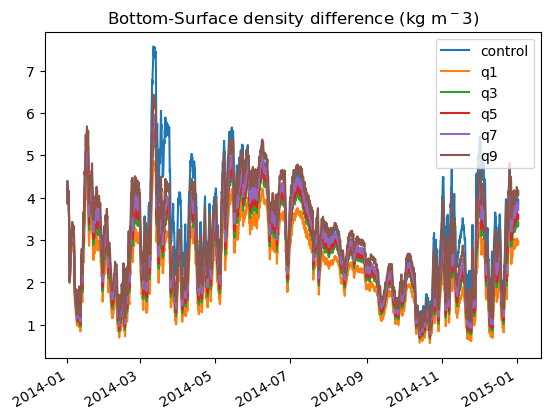

In [10]:
fig, ax = plt.subplots()
for n in dens_deltas_df.columns:
    dens_deltas_df[n].plot(ax=ax)
ax.set_title('Bottom-Surface density difference (kg m$^-3$)')
ax.legend()
fig.savefig('results/puget_sound/densdelta.png');

In [11]:
dens_deltas_df.to_excel('results/puget_sound/densdelta.xlsx')

In [12]:
data.close()